# Field Reversed Configuration (FRC) Simulations

The FRC formed through an RMF can be characterized by two important dimensionless parameters, $\lambda=R/\delta$, where $\delta=(2\eta /\mu_o \omega)^{1/2}$ is the classical skin depth, and by $\gamma=\omega_{ce}/\nu_{ei}$, where $\nu_{ei}=\eta(ne^2/m_e)$ is the electron-ion collision frequency. In term of the system parameters, these two parameters can be expressed as

$$ \lambda = R \left(\frac{\mu_o\omega}{2\eta}\right)^{1/2} $$,

$$ \gamma = \frac{1}{e}\left(\frac{B_\omega}{n\eta}\right) $$.

The magnitude of the external-driving field must exceed a certain critical value before much current is driven in the plasma column.

The measure of the current drive is the parameter $\alpha$, which is defined as the ratio of the driven current divided by the current obtained if all of the electrons rotate synchronously with the RMF.

$$ \alpha = \frac{2}{\mu_o n e \omega R^2}\left(B_z(r=R) - B(r=0) \right) $$

In [93]:
#######  IMPORTS ###########
import os
import re
#import vtk

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

#from vtk.util.numpy_support import vtk_to_numpy

# import pandas and seaborn
import pandas as pd
#import seaborn as sns

# import keras functions
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

#import scikit-learn function
from sklearn.preprocessing import StandardScaler

In [84]:
def plot_regions_and_data(X, y, classifier,scaler,title):
    
    X_set, y_set = X, y
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Areas = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    
    
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Xit = scaler.inverse_transform(np.array([X1.ravel(), X2.ravel()]).T)
    X1 = Xit[:,0].reshape(X1.shape)
    X2 = Xit[:,1].reshape(X2.shape)    
    
    plt.figure(figsize=(14,9))
    levels = np.linspace(0.,1.,21)
    sc = plt.contourf(X1,X2,Areas,levels, cmap='PiYG',origin='lower')
    plt.colorbar(sc, label='Probability of Reversal')
    
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    
    X_set = scaler.inverse_transform(X)
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set==j, 0], X_set[y_set==j,1],
                    c=ListedColormap(('red','green'))(i), s=280, alpha=0.7)
    
    xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
    plt.plot(xx,gammaCritical(xx),'b--',lw=4.)
    
    plt.title(title)
    plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
    plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
    plt.legend()

No handles with labels found to put in legend.


Text(7.5,12,'$\\gamma_c$')

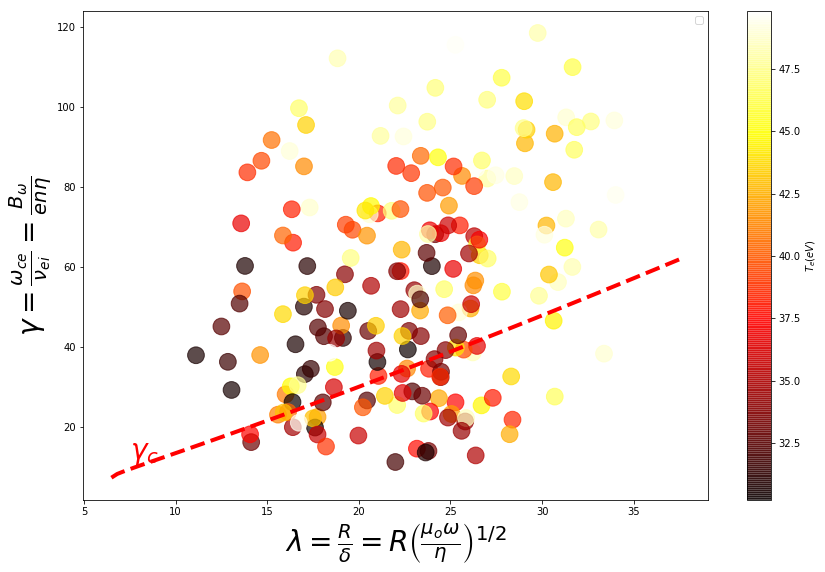

In [6]:
number = 200 # Sample size

def calRatio(w, Bw, Te):
    mu_o = np.pi*4.e-7
    e = 1.602e-19

    n = 1.0e20
    R = 0.03
    loglambda = 10.

    eta = 5.2e-5*loglambda/(Te)**1.5
    #eta = 1.65e-9*loglambda/(Te/1.e3)**1.5

    gamma = Bw/e/n/eta
    lmbda = R*np.sqrt(0.5*mu_o*w/eta)

    return gamma, lmbda

def gammaCritical(lbd):
    return 1.12*lbd*(1.0+0.12*(lbd-6.5)**0.4)

def getSelectionInRange(var, rmin, rmax, sample):
    a = np.where(var>rmin)
    b = np.where(var<rmax)
    intersec = np.intersect1d(a,b)

    if(sample<len(intersec)):
        randSample = np.random.randint(len(intersec), size=sample)
        res = intersec[randSample]
    else:
        res = intersec

    return res

omega = np.zeros(number)
Bomega= np.zeros(number)
Temp  = np.zeros(number)
lam   = np.zeros(number)
gam   = np.zeros(number)
gol   = np.zeros(number)

np.random.seed(4)
for k in range(number):
    omega[k] = np.random.uniform(2*np.pi*1.e5,2*np.pi*5.e5)
    Bomega[k]= np.random.uniform(5.e-4,30.e-4)
    Temp[k]  = np.random.uniform(30.,50.)
    gam[k], lam[k]   = calRatio(omega[k], Bomega[k], Temp[k])
    gol[k] = gam[k]/lam[k]

plt.figure(figsize=(14,9))
sc = plt.scatter(lam, gam, c=Temp, cmap="hot", alpha=0.7,s=280)

cb = plt.colorbar(sc, label=r'$T_e (eV)$')
plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')

For each of the points in the scatter plot an Apollo simulations was run.

In [9]:
time = 51
component = 0

# get a list of all sub-directories in thedir
thedir  = '/home/sousae/simulationsApollo/rmf_frc/dataAnalysis'
subdirs = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]
if '.ipynb_checkpoints' in subdirs: subdirs.remove('.ipynb_checkpoints') ### I get this weird sting in there somehow

frc = np.genfromtxt(os.path.join(thedir)+'/frc_post_data.txt')    
    
#reader = vtk.vtkXMLUnstructuredGridReader()

# this function extracts the RMF frequency, RMF field magnitude, and the electron temperature at initialization
#def getSimulationParameters(filename):
#    f=open(filename)
#    lines = f.readlines()
#    om = re.findall("\d+\.\d+",lines[2])
#    Bo = re.findall("\d+\.\d+",lines[3])
#    Te = re.findall("\d+\.\d+",lines[4])
    
#    return float(om[0]), float(Bo[0]), float(Te[0])
    
#################### this is used to get the dimensions of the dataset per output file #####
#d = np.loadtxt(thedir+'/simulation_values.txt')
#folder = 'gammaOverGamma_crit_0.804947683677'
#filename = os.path.join(thedir,folder)+'/frc2d_2Fluid_000.vtu'
#reader = vtk.vtkXMLUnstructuredGridReader()
#reader.SetFileName(filename)
#reader.Update()
#size = len( vtk_to_numpy( reader.GetOutput().GetPointData().GetArray(component) ) )
############################################################################################

#dataB = np.zeros((size,time))
#dataR = np.zeros((size,time))
#minBz= np.zeros(time)

#frc = np.zeros((len(subdirs),12))

# Loop over all sample test cases
#for s in range(len(subdirs)):
    # get the values of omega, b_omega, and Te for this sample
#    frc[s,0], frc[s,1], frc[s,2] = getSimulationParameters(os.path.join(thedir,subdirs[s])+'/frc2d.pin')
    #calculate gamma, lambda and gamma/gammaCritical
#    frc[s,4], frc[s,3]   = calRatio(frc[s,0], frc[s,1], frc[s,2])
#    frc[s,5] = frc[s,4]/gammaCritical(frc[s,3])
    
    # loop over all time slices
#    for k in range(time):
#        filename = os.path.join(thedir,subdirs[s])+'/frc2d_2Fluid_'+str('%03d' % k)+'.vtu'
#        reader.SetFileName(filename)
#        reader.Update()
#        dataB[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(15)) # Bz
#        dataR[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(0)) # electron density
#        minBz[k]  = min(dataB[:,k])
        
    ### Do a SVD
#    U, sB, V = np.linalg.svd(dataB, full_matrices=False)
#    U, sR, V = np.linalg.svd(dataR, full_matrices=False)
    
    ### Get the first singular value for Bz SVD
#    frc[s,6] = sB[0]
#    frc[s,7] = sB[0]/sB.sum()
    
    ### Get the first singular value for rho_e SVD
#    frc[s,8] = sR[0]
#    frc[s,9] = sR[0]/sR.sum()
    
#    frc[s,10] = dataB.min()
#    frc[s,11] = (1. if dataB.min() < 0. else 0.)
#plt.figure(figsize=(14,9))
#plt.subplot(421), plt.plot(s/sum(s),'bo', markersize=12)
#plt.subplot(423), plt.plot(U[:,0],'b',lw=2)
#plt.subplot(425), plt.plot(U[:,1],'r',lw=2)
#plt.subplot(427), plt.plot(U[:,2],'g',lw=2)

#plt.subplot(422), plt.plot(minBz,lw=2)
#plt.subplot(422), plt.plot(plasmaFreqe,'r',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqi,'g',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqp,'m',lw=2)
#plt.subplot(424), plt.plot(V[0,:],'b',lw=2)
#plt.subplot(426), plt.plot(V[1,:],'r',lw=2)
#plt.subplot(428), plt.plot(V[2,:],'g',lw=2)
#np.savetxt(os.path.join(thedir,subdirs[s])+'/frc_testSamplesData.txt', frc)
print('Done.')

Done.


Text(7.5,12,'$\\gamma_c$')

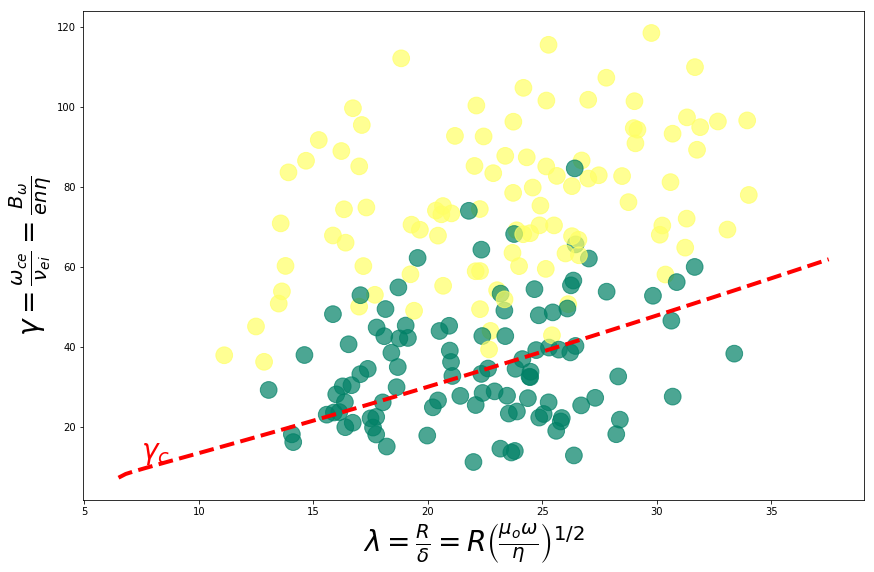

In [10]:
plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,11], cmap="summer", alpha=0.7,s=280)

#cb = plt.colorbar(sc, label=r'$B_z Reversal$')
#plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')

In [11]:
df = pd.DataFrame(frc, columns=['omega', 'Bomega', 'Te', 'lambda', 'gamma', 'gammaOverCrit', 'svd_bz', 
                                'svd_bz_per', 'svd_rho', 'svd_rho_perc', 'minBz', 'reversal'])

df["Bz_negative"] = df['reversal'].astype('category')

In [12]:
#fig, ax = plt.subplots(figsize=(14,9))
#sns.lmplot(x= 'lambda', y= 'gamma', data=df, hue='Bz_negative', palette='Set1', size=280)

The prediction pattern is complex, therefore a ddep learning neural network will be developed in an attempt to predict the test cases reversal.

In [104]:
# setup need variables

predictors = frc[:,3:5]
target = to_categorical(frc[:,11])[:,1]


n_cols = predictors.shape[1]

# scale the predictors
scaler = StandardScaler()
scaler.fit(predictors)
predictors_scaled = scaler.transform(predictors)

def create_model_given_activation(act, predict=predictors_scaled, targ=target, ncols=n_cols):
    model = Sequential()
    model.add(Dense(50, init = 'uniform', activation=act, input_shape = (ncols,)))
    model.add(Dense(50, init = 'uniform', activation=act))
    model.add(Dense(50, init = 'uniform', activation=act))
    model.add(Dense(1, init = 'uniform', activation='sigmoid'))
    
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # fit the model with early stopping
    early_stopping_monitor = EarlyStopping(patience=2)
    history = model.fit(predict, targ, validation_split=0.3, epochs=30,
                        callbacks = [early_stopping_monitor])
    
    return history    

In [105]:
# create a model
activation = 'relu'

history = create_model_given_activation(activation)

/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(150, activation="relu", input_shape=(2,), kernel_initializer="uniform")`
  app.launch_new_instance()
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(150, activation="relu", kernel_initializer="uniform")`
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(150, activation="relu", kernel_initializer="uniform")`
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(150, activation="relu", kernel_initializer="uniform")`
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call t

Train on 140 samples, validate on 60 samples
Epoch 1/30
140/140 [==============================] - 1s 11ms/step - loss: 0.6930 - acc: 0.4643 - val_loss: 0.6922 - val_acc: 0.5500
Epoch 2/30
140/140 [==============================] - 0s 159us/step - loss: 0.6906 - acc: 0.7214 - val_loss: 0.6867 - val_acc: 0.8500
Epoch 3/30
140/140 [==============================] - 0s 295us/step - loss: 0.6822 - acc: 0.8714 - val_loss: 0.6684 - val_acc: 0.9333
Epoch 4/30
140/140 [==============================] - 0s 252us/step - loss: 0.6576 - acc: 0.8714 - val_loss: 0.6201 - val_acc: 0.9167
Epoch 5/30
140/140 [==============================] - 0s 240us/step - loss: 0.5982 - acc: 0.8571 - val_loss: 0.5184 - val_acc: 0.9167
Epoch 6/30
140/140 [==============================] - 0s 365us/step - loss: 0.4875 - acc: 0.8786 - val_loss: 0.3477 - val_acc: 0.9167
Epoch 7/30
140/140 [==============================] - 0s 233us/step - loss: 0.3603 - acc: 0.8786 - val_loss: 0.2153 - val_acc: 0.9167
Epoch 8/30
140/140

In [74]:
# create a new model
activation = 'linear'

history2 = create_model_given_activation(activation)

/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="linear", input_shape=(2,), kernel_initializer="uniform")`
  app.launch_new_instance()
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="linear", kernel_initializer="uniform")`
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="linear", kernel_initializer="uniform")`
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


Train on 140 samples, validate on 60 samples
Epoch 1/30
140/140 [==============================] - 1s 6ms/step - loss: 0.6930 - acc: 0.4643 - val_loss: 0.6925 - val_acc: 0.4333
Epoch 2/30
140/140 [==============================] - 0s 66us/step - loss: 0.6910 - acc: 0.5643 - val_loss: 0.6901 - val_acc: 0.5167
Epoch 3/30
140/140 [==============================] - 0s 294us/step - loss: 0.6869 - acc: 0.6500 - val_loss: 0.6841 - val_acc: 0.6667
Epoch 4/30
140/140 [==============================] - 0s 101us/step - loss: 0.6785 - acc: 0.7000 - val_loss: 0.6707 - val_acc: 0.7500
Epoch 5/30
140/140 [==============================] - 0s 178us/step - loss: 0.6598 - acc: 0.7214 - val_loss: 0.6442 - val_acc: 0.8000
Epoch 6/30
140/140 [==============================] - 0s 159us/step - loss: 0.6288 - acc: 0.7571 - val_loss: 0.5981 - val_acc: 0.8167
Epoch 7/30
140/140 [==============================] - 0s 194us/step - loss: 0.5785 - acc: 0.8000 - val_loss: 0.5248 - val_acc: 0.8500
Epoch 8/30
140/140 [

In [75]:
activation = 'sigmoid'

history3 = create_model_given_activation(activation)

/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="sigmoid", input_shape=(2,), kernel_initializer="uniform")`
  app.launch_new_instance()
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="sigmoid", kernel_initializer="uniform")`
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="sigmoid", kernel_initializer="uniform")`
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


Train on 140 samples, validate on 60 samples
Epoch 1/30
140/140 [==============================] - 1s 6ms/step - loss: 0.6914 - acc: 0.5429 - val_loss: 0.7014 - val_acc: 0.4333
Epoch 2/30
140/140 [==============================] - 0s 69us/step - loss: 0.6902 - acc: 0.5429 - val_loss: 0.7075 - val_acc: 0.4333
Epoch 3/30
140/140 [==============================] - 0s 157us/step - loss: 0.6897 - acc: 0.5429 - val_loss: 0.7078 - val_acc: 0.4333


In [76]:
activation = 'tanh'

history4 = create_model_given_activation(activation)

/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="tanh", input_shape=(2,), kernel_initializer="uniform")`
  app.launch_new_instance()
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="tanh", kernel_initializer="uniform")`
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="tanh", kernel_initializer="uniform")`
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


Train on 140 samples, validate on 60 samples
Epoch 1/30
140/140 [==============================] - 1s 6ms/step - loss: 0.6930 - acc: 0.4143 - val_loss: 0.6916 - val_acc: 0.8833
Epoch 2/30
140/140 [==============================] - 0s 126us/step - loss: 0.6907 - acc: 0.7643 - val_loss: 0.6885 - val_acc: 0.7667
Epoch 3/30
140/140 [==============================] - 0s 118us/step - loss: 0.6860 - acc: 0.7143 - val_loss: 0.6807 - val_acc: 0.7833
Epoch 4/30
140/140 [==============================] - 0s 153us/step - loss: 0.6755 - acc: 0.7571 - val_loss: 0.6633 - val_acc: 0.8500
Epoch 5/30
140/140 [==============================] - 0s 165us/step - loss: 0.6545 - acc: 0.8286 - val_loss: 0.6325 - val_acc: 0.8500
Epoch 6/30
140/140 [==============================] - 0s 155us/step - loss: 0.6187 - acc: 0.8286 - val_loss: 0.5811 - val_acc: 0.8500
Epoch 7/30
140/140 [==============================] - 0s 172us/step - loss: 0.5657 - acc: 0.8357 - val_loss: 0.5078 - val_acc: 0.8500
Epoch 8/30
140/140 

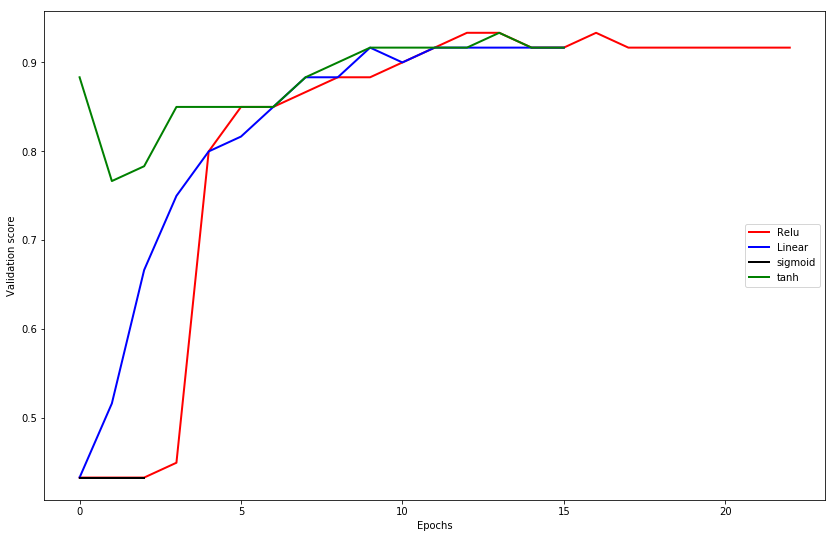

In [77]:
# Create the plot
plt.figure(figsize=(14,9))
plt.plot(history.history['val_acc'], 'r', label='Relu', lw=2, markersize=20)
plt.plot(history2.history['val_acc'], 'b', label='Linear', lw=2, markersize=20)
plt.plot(history3.history['val_acc'], 'k', label='sigmoid', lw=2, markersize=20)
plt.plot(history4.history['val_acc'], 'g', label='tanh', lw=2, markersize=20)
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend(loc='center right')

In [110]:
ann_relu = Sequential()
ann_relu.add(Dense(50, init = 'uniform', activation='relu', input_shape = (2,)))
ann_relu.add(Dense(50, init = 'uniform', activation='relu'))
ann_relu.add(Dense(50, init = 'uniform', activation='relu'))
ann_relu.add(Dense(1, init = 'uniform', activation='sigmoid'))
    
# compile the model
ann_relu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
# fit the model with early stopping
early_stopping_monitor = EarlyStopping(patience=2)
history = ann_relu.fit(predictors_scaled, target, validation_split=0.25, epochs=30,
                    callbacks = [early_stopping_monitor])

/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", input_shape=(2,), kernel_initializer="uniform")`
  
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/sousae/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="tanh", kernel_initializer="uniform")`
  """


Train on 150 samples, validate on 50 samples
Epoch 1/30
150/150 [==============================] - 1s 7ms/step - loss: 2.9212 - acc: 0.5333 - val_loss: 2.7809 - val_acc: 0.4400
Epoch 2/30
150/150 [==============================] - 0s 63us/step - loss: 2.2015 - acc: 0.5333 - val_loss: 2.4394 - val_acc: 0.4400
Epoch 3/30
150/150 [==============================] - 0s 140us/step - loss: 1.9610 - acc: 0.5333 - val_loss: 2.2033 - val_acc: 0.4400
Epoch 4/30
150/150 [==============================] - 0s 135us/step - loss: 1.7653 - acc: 0.5333 - val_loss: 1.9975 - val_acc: 0.4400
Epoch 5/30
150/150 [==============================] - 0s 86us/step - loss: 1.5995 - acc: 0.5333 - val_loss: 1.7973 - val_acc: 0.4400
Epoch 6/30
150/150 [==============================] - 0s 158us/step - loss: 1.4394 - acc: 0.5333 - val_loss: 1.6008 - val_acc: 0.4400
Epoch 7/30
150/150 [==============================] - 0s 165us/step - loss: 1.2826 - acc: 0.5333 - val_loss: 1.4103 - val_acc: 0.4400
Epoch 8/30
150/150 [=

In [86]:
X_set, y_set = predictors_scaled, target
X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                     np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))

In [88]:
Areas = ann_relu.predict_proba(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)

In [89]:
X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                     np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))

Xit = scaler.inverse_transform(np.array([X1.ravel(), X2.ravel()]).T)
X1 = Xit[:,0].reshape(X1.shape)
X2 = Xit[:,1].reshape(X2.shape)

Text(0,0.5,'$\\gamma = \\frac{\\omega_{ce}}{\\nu_{ei}} = \\frac{B_\\omega}{en\\eta}$')

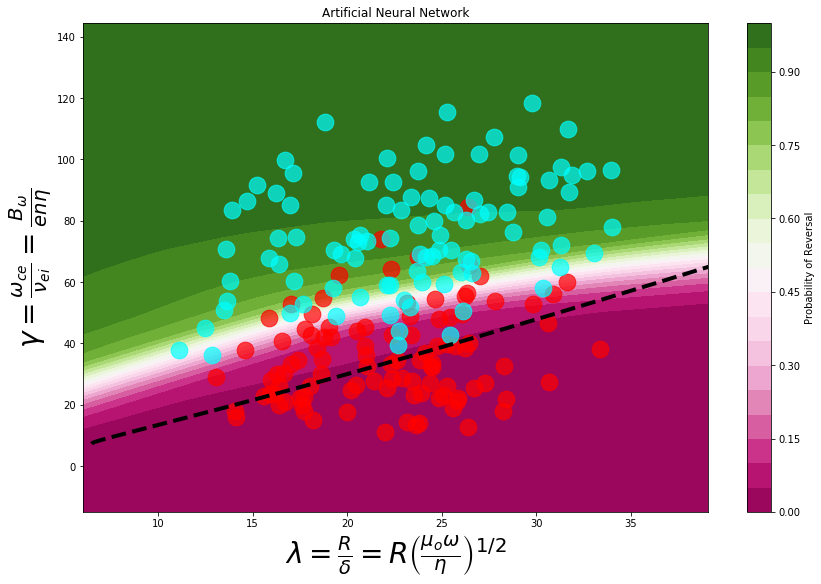

In [107]:
plt.figure(figsize=(14,9))
levels = np.linspace(0.,1.,21)
sc = plt.contourf(X1,X2,Areas,levels, cmap='PiYG',origin='lower')
plt.colorbar(sc, label='Probability of Reversal')
    
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

X_set = scaler.inverse_transform(predictors_scaled)
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set==j, 0], X_set[y_set==j,1],
                c=ListedColormap(('red','cyan'))(i), s=280, alpha=0.7)
    
#xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
xx = np.linspace(6.5, 40., 1000)
plt.plot(xx,gammaCritical(xx),'k--',lw=4.)

plt.title("Artificial Neural Network")
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.legend()